In [100]:
import random

class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env

        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()      # Q-table which will be a dictionary of tuples
        self.epsilon = 0     # Random exploration factor
        self.alpha = 0       # Learning factor
        self.gamma = 0       # Discount factor- closer to 1 learns well into distant future
        self.num_episodes_to_train = 0
    
    def init_decay(self,num_episodes_to_train):
        self.num_episodes_to_train = num_episodes_to_train
        self.small_decrement = (0.1 * self.epsilon) / (0.3 * self.num_episodes_to_train)
        self.big_decrement = (0.8 * self.epsilon) / (0.4 * self.num_episodes_to_train)

        self.num_episodes_to_train_left = self.num_episodes_to_train

    def update_parameters(self):
        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        self.create_Q_if_new_observation(observation)
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action
    
    def get_action(self, observation):
        self.create_Q_if_new_observation(observation)
        maxQ = self.get_maxQ(observation)
        return random.choice([k for k in self.Q[observation].keys()
                                if self.Q[observation][k] == maxQ])


    def learn(self, observation, action, reward, next_observation):
        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])
        
    def train(self, **params):
        # parameters
        self.gamma = params.pop('gamma', 0.2)
        self.alpha = params.pop('alpha', 0.5)
        self.epsilon= params.pop('epsilon', 1.0)
        num_samples= params.pop('num_samples', 1000) 
        num_rounds= params.pop('num_rounds', 1000)
        num_episodes_to_train = params.pop('num_episodes_to_train',800)
        
        self.init_decay(num_episodes_to_train)
        
        average_payouts = []

        observation = env.reset()
        for sample in range(num_samples):
            round = 1
            total_payout = 0
            while round <= num_rounds:
                action = agent.choose_action(observation)
                next_observation, payout, is_done, _ = env.step(action)
                
                self.learn(observation, action, payout, next_observation)
                
                total_payout += payout
                observation = next_observation
                if is_done:
                    observation = env.reset()
                    round += 1
            average_payouts.append(total_payout)
        return average_payouts
    
    def test(self):
        observation = env.reset()
        print("Inital State",observation)
        total_payout = 0
        is_done =False
        while not is_done:
            action = agent.get_action(observation)
            if(action == 0):
                print("stay")
            else:
                print("Hit")
            next_observation, payout, is_done, _ = env.step(action)
            print("Next State",next_observation, _)
            total_payout += payout
            observation = next_observation
            if is_done:
                observation = env.reset()
        return total_payout
    
    def show_strategy(self):
        list_players_hand = range(1, 22)
        list_dealers_upcard = range(1, 11)
        # Print headers to give more information about output
        print ("{:^10} | {:^51} | {:^51}".format("Player's","Dealer's upcard when ace is not usable", "Dealer's upcard when ace is usable"))
        print ("{0:^10} | {1} | {1}".format("Hand", [str(upcard) if not upcard==1 else 'A' 
                                                        for upcard in list_dealers_upcard]))
        for players_hand in list_players_hand:
            actions_usable = []
            actions_not_usable = []
            for dealers_upcard in list_dealers_upcard:
                observation = (players_hand, dealers_upcard, False)
                actions_not_usable.append(self.readable_action(observation))
                observation = (players_hand, dealers_upcard, True)
                actions_usable.append(self.readable_action(observation))
            print ("{:>10} | {}  | {}".format(players_hand, actions_not_usable, actions_usable))

    def readable_action(self,observation):
        """ 
        Pass observation to agent and get human readable action
        H is hit, S is stick and '-' means the state is unseen and a random action is taken
        """
        if observation not in self.Q:
            action = "-"
        else:
            action = "H" if self.get_action(observation) else "S"    
        return action
    

In [101]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """
    Taken from Open AI Gym and modified to display the sum of delers hand instead of just first card
    
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1:
                reward = 1.5
        return self._get_obs(), reward, done, {sum_hand(self.dealer)}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

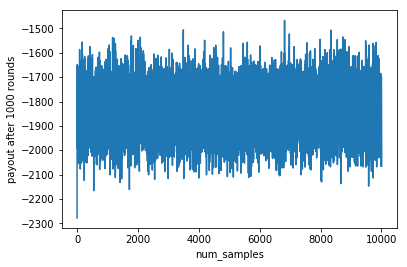

Average payout after 10000 rounds is -1838.3586


In [106]:
import gym
# env = gym.make('Blackjack-v0')
env = BlackjackEnv()
import matplotlib.pyplot as plt

agent = Agent(env)
num_rounds = 10000
num_samples = 10000
num_episodes_to_train = 0.8* num_rounds
# epsilon=1.0, alpha=0.5, gamma=0.2
average_payouts = agent.train(epsilon=1.0, alpha=0.8, gamma=0.1,num_rounds = num_rounds,num_samples = num_samples,num_episodes_to_train=num_episodes_to_train)


# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

In [103]:
rew = agent.test()
print(rew)

Inital State (11, 3, False)
Hit
Next State (14, 3, False) {13}
Hit
Next State (16, 3, False) {13}
stay
Next State (16, 3, False) {17}
-1.0


In [107]:
agent.show_strategy()

 Player's  |       Dealer's upcard when ace is not usable        |         Dealer's upcard when ace is usable         
   Hand    | ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'] | ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']
         1 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']  | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         2 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']  | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         3 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']  | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         4 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']  | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         5 | ['H', 'S', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']  | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         6 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'S', 'H', 'H']  | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         7 | ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 